In [1]:
# imports

import pandas as pd 
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# data preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import wordnet 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# TextBlob to label text
from textblob import TextBlob

# split data 
from sklearn.model_selection import train_test_split

# change text to numerical form
from sklearn.feature_extraction.text import CountVectorizer

# training the mode
from sklearn import model_selection
from sklearn import svm

# to evaluate the results of the models
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

# to find the best parameter
from sklearn.pipeline import Pipeline
from sklearn import set_config

# to save the pipeline 
from joblib import dump
from joblib import load

In [2]:
# read the original dataset 
df = pd.read_csv("cyberbullying_tweets.csv")

#to set the column width to maximum 
pd.set_option('display.max_colwidth',150)

In [3]:
# drop this column because will label it using TextBlob
df.drop(["cyberbullying_type"], axis = 1, inplace = True)

In [4]:
df.head()

,tweet_text
0,"In other words #katandandre, your food was crapilicious! #mkr"
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter."
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies."


In [5]:
# to check if there are missing values
df.isna().sum()

tweet_text    0
dtype: int64

In [6]:
# to convert uppercase to lowercase characters
def lower_word(t):
    new_text = "".join(t.lower())
    return new_text

df['lowercased'] = df['tweet_text'].apply(lambda x: lower_word(x))

In [7]:
# remove usernames, url and non utf8/ascii characters 
def rem_url(t):
    text1 = "".join(re.sub(r'(?:\@|https?\://)\S+', '', t))
    text = "".join(re.sub(r'[^\x00-\x7f]',r'', text1))
    return text

df['no_url_and_username'] = df['lowercased'].apply(lambda x: rem_url(x))

In [8]:
# to remove punctuation 
def rem_punc(t):
        new_text = "".join(re.sub(r'[^\w\s]', '', t))
        return new_text
    
df['no_punctuation'] = df['no_url_and_username'].apply(lambda x: rem_punc(x))

In [9]:
# to break the sentence into tokens
def create_token(t):
        token_text = " ".join(word_tokenize(t))
        return token_text
    
df['tokenized'] = df['no_punctuation'].apply(lambda x: create_token(x))

In [10]:
# split strings into list and join as string 
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.extend(['rt', 'mkr', 'httpâ', 'tvwâ', 'etc'])

def rem_stopword(t):
    new_text = " ".join([word for word in t.split() if word not in stop_words])
    return new_text

df['no_stopwords'] = df['tokenized'].apply(lambda x: rem_stopword(x))

In [11]:
# total number of rows after datapreprocessing
df.shape

(47692, 6)

In [12]:
# to check for duplicated cells after cleaning
df.duplicated().sum()

1686

In [13]:
# drop duplicated cells
df.drop_duplicates("no_stopwords",inplace=True)

In [14]:
# to show number of duplicated cells
df.duplicated().sum()

0

In [15]:
# WORDNET LEMMATIZER (with appropriate pos tags)
def lemma_postag(t):
    lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(t))

    # our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence


In [16]:
# to lemmatize the words
df['lemmatization_postag'] = df['no_stopwords'].apply(lambda x: lemma_postag(x))

In [17]:
# to view at preprocessed data
df.head()

,tweet_text,lowercased,no_url_and_username,no_punctuation,tokenized,no_stopwords,lemmatization_postag
0,"In other words #katandandre, your food was crapilicious! #mkr","in other words #katandandre, your food was crapilicious! #mkr","in other words #katandandre, your food was crapilicious! #mkr",in other words katandandre your food was crapilicious mkr,in other words katandandre your food was crapilicious mkr,words katandandre food crapilicious,word katandandre food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,why is #aussietv so white? #mkr #theblock #imacelebrityau #today #sunrise #studio10 #neighbours #wonderlandten #etc,why is #aussietv so white? #mkr #theblock #imacelebrityau #today #sunrise #studio10 #neighbours #wonderlandten #etc,why is aussietv so white mkr theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc,why is aussietv so white mkr theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc,aussietv white theblock imacelebrityau today sunrise studio10 neighbours wonderlandten,aussietv white theblock imacelebrityau today sunrise studio10 neighbour wonderlandten
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,@xochitlsuckkks a classy whore? or more red velvet cupcakes?,a classy whore? or more red velvet cupcakes?,a classy whore or more red velvet cupcakes,a classy whore or more red velvet cupcakes,classy whore red velvet cupcakes,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.","@jason_gio meh. :p thanks for the heads up, but not too concerned about another angry dude on twitter.","meh. :p thanks for the heads up, but not too concerned about another angry dude on twitter.",meh p thanks for the heads up but not too concerned about another angry dude on twitter,meh p thanks for the heads up but not too concerned about another angry dude on twitter,meh p thanks heads not concerned another angry dude twitter,meh p thanks head not concern another angry dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.","@rudhoeenglish this is an isis account pretending to be a kurdish account. like islam, it is all lies.","this is an isis account pretending to be a kurdish account. like islam, it is all lies.",this is an isis account pretending to be a kurdish account like islam it is all lies,this is an isis account pretending to be a kurdish account like islam it is all lies,isis account pretending kurdish account like islam lies,isi account pretend kurdish account like islam lie


In [18]:
# to drop all columns except for cleaned_tweet and original_tweet

clean_data = df.drop(['lowercased', 'no_url_and_username', 'no_punctuation', 'no_stopwords', 'tokenized'], axis = 1)
clean_data.rename(columns = {"lemmatization_postag":"cleaned_tweet"}, inplace = True)
clean_data.rename(columns = {"tweet_text":"original_tweet"}, inplace = True)

clean_data.head()

,original_tweet,cleaned_tweet
0,"In other words #katandandre, your food was crapilicious! #mkr",word katandandre food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,aussietv white theblock imacelebrityau today sunrise studio10 neighbour wonderlandten
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",meh p thanks head not concern another angry dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",isi account pretend kurdish account like islam lie


In [19]:
# use TextBlob to find out the polarity of the sentence to use it as the target variable during training

def getPolarity_TB(t):
    result = TextBlob(t).sentiment.polarity
    return result

In [20]:
# create a new table to label the sentences
text_blob = clean_data.copy(deep=True)

text_blob['polarity'] = text_blob['cleaned_tweet'].apply(getPolarity_TB)

In [21]:
text_blob.head()

,original_tweet,cleaned_tweet,polarity
0,"In other words #katandandre, your food was crapilicious! #mkr",word katandandre food crapilicious,0.00
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,aussietv white theblock imacelebrityau today sunrise studio10 neighbour wonderlandten,0.00
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,classy whore red velvet cupcake,0.05
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",meh p thanks head not concern another angry dude twitter,-0.15
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",isi account pretend kurdish account like islam lie,0.00


In [22]:
# to label the text based on polarity score 
def getLabel(polarity):
    if polarity < 0:
        return 'Negative'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [23]:
text_blob['label'] = text_blob['polarity'].apply(getLabel)

In [24]:
text_blob.head()

,original_tweet,cleaned_tweet,polarity,label
0,"In other words #katandandre, your food was crapilicious! #mkr",word katandandre food crapilicious,0.00,Neutral
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,aussietv white theblock imacelebrityau today sunrise studio10 neighbour wonderlandten,0.00,Neutral
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,classy whore red velvet cupcake,0.05,Positive
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",meh p thanks head not concern another angry dude twitter,-0.15,Negative
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",isi account pretend kurdish account like islam lie,0.00,Neutral


In [25]:
# to drop all text labelled as "Neutral"
text_blob.drop(text_blob[text_blob['label'] == "Neutral"].index, inplace=True)

In [26]:
# to check the shape of the data
text_blob.shape

(34848, 4)

In [27]:
# to change the target variable to numerical form for training and testing
text_blob['target'] = text_blob['label'].apply(lambda label : 1 if label == "Negative" else 0)

In [28]:
# to check the shape of the data
text_blob.shape

(34848, 5)

In [31]:
text_blob.head()

,original_tweet,cleaned_tweet,polarity,label,target
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,classy whore red velvet cupcake,0.050000,Positive,0
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",meh p thanks head not concern another angry dude twitter,-0.150000,Negative,1
5,"@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.",yes test god good bad indifferent weird whatever prove god existence,-0.166667,Negative,1
7,Karma. I hope it bites Kat on the butt. She is just nasty. #mkr,karma hope bite kat butt nasty,-1.000000,Negative,1
8,@stockputout everything but mostly my priest,everything mostly priest,0.500000,Positive,0


In [33]:
# need to change the index number of columns in excel 
# this step is not executed to preserve the original data 

# text_blob.to_csv('cleaned_table_final.csv') 

In [34]:
# load the new table with rearranged index number 
data = pd.read_csv("cleaned_table_final_rearranged.csv")

In [35]:
#using all data
x = data['cleaned_tweet'] #feature
y = data['target'] #target

In [36]:
print(x.shape)
print(y.shape)

(34848,)
(34848,)


In [ ]:
# to check the distribution of data in each class

x=data['target'].value_counts()
sns.barplot(x.index,x)

sum = x[0] + x[1]
percentage_positive = (x[0]/sum)*100
percentage_negative = (x[1]/sum)*100
diff = percentage_negative - percentage_positive

print("Percentage of positive class (0) : {:.2f}%".format(percentage_positive))
print("Percentage of negative class (1) : {:.2f}%".format(percentage_negative))
print("Difference between two classes : {:.2f}%".format(diff))


In [37]:
# split data into train data and test data

x_train, x_test, y_train_label, y_test_label = train_test_split(x, y, test_size=0.2, random_state = 42)

print("x_train shape {} , x_test shape {} ".format(x_train.shape, x_test.shape))
print("y_train shape {} , y_test shape {} ".format(y_train_label.shape, y_test_label.shape))

x_train shape (27878,) , x_test shape (6970,) 
y_train shape (27878,) , y_test shape (6970,) 


In [38]:
# change text to numerical form with BOW 

# BOW
print("Bag of Words……")
my_stopWords = stop_words
count_vectorizer = CountVectorizer(stop_words= my_stopWords)
bow_vector_final = count_vectorizer.fit(x_train)
bow_x_train_final = count_vectorizer.transform(x_train)

bow_x_test_final = count_vectorizer.transform(x_test)

Bag of Words……


In [43]:
# train the model and test the model

final_model = svm.SVC(C=0.1, kernel='linear', random_state = 42, probability=True)
final_model = sklearn.base.clone(final_model)

final_model.fit(bow_x_train_final, y_train_label)
final_model_predicted = final_model.predict(bow_x_test_final)

Support Vector Machine
0.9261119081779053
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3245
           1       0.94      0.92      0.93      3725

    accuracy                           0.93      6970
   macro avg       0.93      0.93      0.93      6970
weighted avg       0.93      0.93      0.93      6970



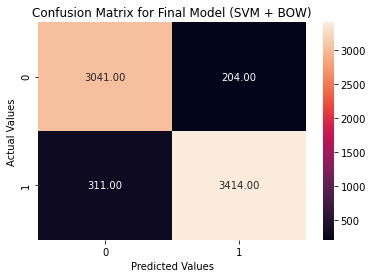

In [44]:
# print classification report
print("Support Vector Machine")
print(accuracy_score(y_test_label, final_model_predicted))
print(classification_report(y_test_label, final_model_predicted))

# print confusion matrix 
final_cm = confusion_matrix(y_test_label, final_model_predicted)
sns.heatmap(final_cm, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Final Model (SVM + BOW)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [46]:
# build pipeline to save model

pipeline = Pipeline([('bow', CountVectorizer(stop_words= my_stopWords)), 
             ('clf', svm.SVC(C=0.1, kernel='linear', random_state = 42, probability=True))])

model = pipeline.fit(x_train, y_train_label)

In [123]:
# look at the accuracy of the model after pipeline
accuracy = model.score(x_test, y_test_label)
accuracy2 = accuracy_score(y_test_label, final_model_predicted)

In [124]:
print('Accuracy score for pipeline model: ', accuracy)
print('Accuracy score for model before pipeline: ', accuracy2)

Accuracy score for pipeline model:  0.9261119081779053
Accuracy score for model before pipeline:  0.9261119081779053


In [121]:
# dump the pipeline model
# load this model into web application for classification
dump(pipeline, filename="text_classification.joblib")

['text_classification.joblib']